In [3]:
import numpy as np
import pandas as pd
import cv2
from glob import glob
import os
import pathlib

#import matplotlib.pyplot as plt
from tqdm import tqdm

ModuleNotFoundError: No module named 'numpy'

In [ ]:
!pip3 

## Img, Label 확인

In [8]:
img_dir = './total/'
result = []
idx = 0

label_list = [f for f in os.listdir(img_dir) if not f.startswith('.')]

for label in label_list:
    file_list = glob(os.path.join(img_dir,label,'*'))
    
    for file in file_list:
        result.append([idx, label, file])
        idx += 1
        
img_df = pd.DataFrame(result, columns=['idx','label','image_path'])
img_df

,idx,label,image_path
0,0,contrabass_pet,./total/contrabass_pet/3917.jpg
1,1,contrabass_pet,./total/contrabass_pet/716.jpg
2,2,contrabass_pet,./total/contrabass_pet/1598.jpg
3,3,contrabass_pet,./total/contrabass_pet/2906.jpg
4,4,contrabass_pet,./total/contrabass_pet/1478.jpg
...,...,...,...
96016,96016,welchs_can,./total/welchs_can/usbcam(2020-06-02-13:53:38)...
96017,96017,welchs_can,./total/welchs_can/usbcam(2020-06-02-12:07:19)...
96018,96018,welchs_can,./total/welchs_can/usbcam(2020-06-02-13:27:17)...
96019,96019,welchs_can,./total/welchs_can/usbcam(2020-06-02-13:27:04)...


In [36]:
plt.figure(figsize=(5,5))
img_df['label'].value_counts().sort_index().plot.barh()

img_df['label'].value_counts().sort_index()

NameError: name 'plt' is not defined

## Augmentation

In [9]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, RandomGamma, VerticalFlip,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue, 
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, RandomContrast, RandomBrightness, RandomCrop, Resize, OpticalDistortion
)

In [15]:
# 음료 classification용

transforms = Compose([
        #Rotate(limit=30, p=0.5),
        #Rotate(limit=180, p=0.5),
        #RandomRotate90(p=1.0)
        #Transpose(p=1.0)
        Resize(248,248, p=0.5),     # resize 후 크롭
        RandomCrop(224,224, p=0.5),  # 위에꺼랑 세트
        
        OneOf([
        RandomContrast(p=1, limit=(-0.1,0.09)),   # -0.5 ~ 2 까지가 현장과 가장 비슷함  -- RandomBrightnessContrast
        RandomBrightness(p=1, limit=(-0.2,0.1)),
        #RandomGamma(p=1, gamma_limit=(80,200)),
        ], p=0.6),
            
        OneOf([
            #Rotate(limit=30, p=0.3),
            #RandomRotate90(p=0.3),
            HorizontalFlip(p=1),
            VerticalFlip(p=1)
        ], p=0.2),
    
        MotionBlur(p=0.1),   # 움직일때 흔들리는 것 같은 이미지
        #ShiftScaleRotate(shift_limit=0.001, scale_limit=0.1, rotate_limit=30, p=0.3, border_mode=1),
        Resize(224,224, p=1),
        ],
        p=1)

In [13]:
transforms = Compose([

        Resize(248,248, p=0.5),     # resize 후 크롭
        RandomCrop(224,224, p=0.5),  # 위에꺼랑 세트
        
        OneOf([
        RandomContrast(p=1, limit=(-0.3,0.1)),   # -0.5 ~ 2 까지가 현장과 가장 비슷함  -- RandomBrightnessContrast
        RandomBrightness(p=1, limit=(-0.3,0.2)),
        #RandomGamma(p=1, gamma_limit=(80,200)),
        ], p=0.6),
            
        OneOf([
            #Rotate(limit=30, p=0.3),
            #RandomRotate90(p=0.3),
            HorizontalFlip(p=1),
            VerticalFlip(p=1)
        ], p=0.2),
    
        MotionBlur(p=0),   # 움직일때 흔들리는 것 같은 이미지
        #ShiftScaleRotate(shift_limit=0.001, scale_limit=0.1, rotate_limit=30, p=0.3, border_mode=1),
        Resize(224,224, p=1),
        ],
        p=1)

In [52]:
# augmentation option 확인

img = cv2.imread(img_df['image_path'][2144])
img = cv2.resize(img,(224,224))
img = cv2.cvtColor(img, cv2.cv2.COLOR_BGR2RGB)
#img = img.reshape((224,224))
img.shape

img1 = transforms(image=img)['image']

f, ax = plt.subplots(1,2,figsize=(10,16))
ax[0].imshow(img)
ax[1].imshow(img1)

ax[0].set_title('initial - {}'.format(img.shape))
ax[1].set_title('transformed - {}'.format(img1.shape))

NameError: name 'plt' is not defined

In [53]:
a = img_df.sample(n=5)['label']

In [54]:
img_df[img_df['label'] == 'power'].sample(n=1)['image_path'].iloc[0]

ValueError: a must be greater than 0 unless no samples are taken

In [16]:
TOTAL_IMG_COUNT = 4000

for label in tqdm(label_list):
    #print(label)
    counts = len(img_df[img_df['label'] == f'{label}'])

    while True:
        if counts < TOTAL_IMG_COUNT:
            img_path = img_df[img_df['label'] == f'{label}'].sample(n=1)['image_path'].iloc[0]
            img = cv2.imread(img_path)
            img = cv2.resize(img,(224,224))
            img = cv2.cvtColor(img, cv2.cv2.COLOR_BGR2RGB)
            img = transforms(image=img)['image']
            img = cv2.cvtColor(img, cv2.cv2.COLOR_RGB2BGR)
            
            cv2.imwrite(os.path.join(img_dir,label,f'aug_{counts + 1}.jpg'), img)
            counts += 1
            #print(counts)
            #print(os.path.join(img_dir,label,f'aug_{counts + 1}.jpg'),' done!!')
            #print('----------------------------------------------------------------')
        else:
            break

100%|██████████| 109/109 [28:59<00:00, 15.96s/it]


In [26]:
label_cnt = []
for label in label_list:
    label_cnt.append([label, len(glob(os.path.join(img_dir,label,'*')))])

pd.DataFrame(label_cnt, columns=['label', 'counts'])

,label,counts
0,redbull_can,3000
1,hwal_pet,3000
2,rice_pet,3000
3,kkaesugang_can,3000
4,ourtea_orange_pet,3000
...,...,...
65,G_sparkling_pet,3000
66,gatorade_pet,3000
67,coca_can,3000
68,demisoda_can,3000


## Object Detection Augmentation

In [4]:
%matplotlib inline
from urllib.request import urlopen
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt


import xml.etree.ElementTree as ET
from xml.dom import minidom


In [74]:
from albumentations import (
    BboxParams,
    HorizontalFlip,
    VerticalFlip,
    Resize,
    CenterCrop,
    RandomCrop,
    Crop,
    Compose
)

In [3]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

In [ ]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params=BboxParams(format='pascal_voc', min_area=min_area, 
                                               min_visibility=min_visibility, label_fields=['category_id']))

In [ ]:
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
from xml.etree.ElementTree import parse

tree = parse('test.xml')
root = tree.getroot()

student = root.findall("student")

name = [x.findtext("name") for x in student]
age = [x.findtext("age") for x in student]
score = [x.find("score").attrib for x in student]


In [31]:
xml_path = '../datasets/od_test/xml/usbcam(2020-03-06-10:56:40).xml'

root = minidom.parse(xml_path)
bnd = root.getElementsByTagName('bndbox')
class_name = root.getElementsByTagName('name')

In [33]:
bnd_1

[<DOM Element: bndbox at 0x7f3f4af75cd0>,
 <DOM Element: bndbox at 0x7f3f4af06370>,
 <DOM Element: bndbox at 0x7f3f4af069b0>,
 <DOM Element: bndbox at 0x7f3f4ae4b050>,
 <DOM Element: bndbox at 0x7f3f4ae4b690>,
 <DOM Element: bndbox at 0x7f3f4ae4bcd0>,
 <DOM Element: bndbox at 0x7f3f4ae55370>,
 <DOM Element: bndbox at 0x7f3f4ae559b0>]

In [39]:
class_name[2].childNodes[0].nodeValue

'hongsam'

In [18]:
for i in range(len(bnd_1)):
    xmin_a = int(bnd_1[i].childNodes[1].childNodes[0].nodeValue)
    ymin_a = int(bnd_1[i].childNodes[3].childNodes[0].nodeValue)
    xmax_a = int(bnd_1[i].childNodes[5].childNodes[0].nodeValue)
    ymax_a = int(bnd_1[i].childNodes[7].childNodes[0].nodeValue)


In [ ]:
def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img

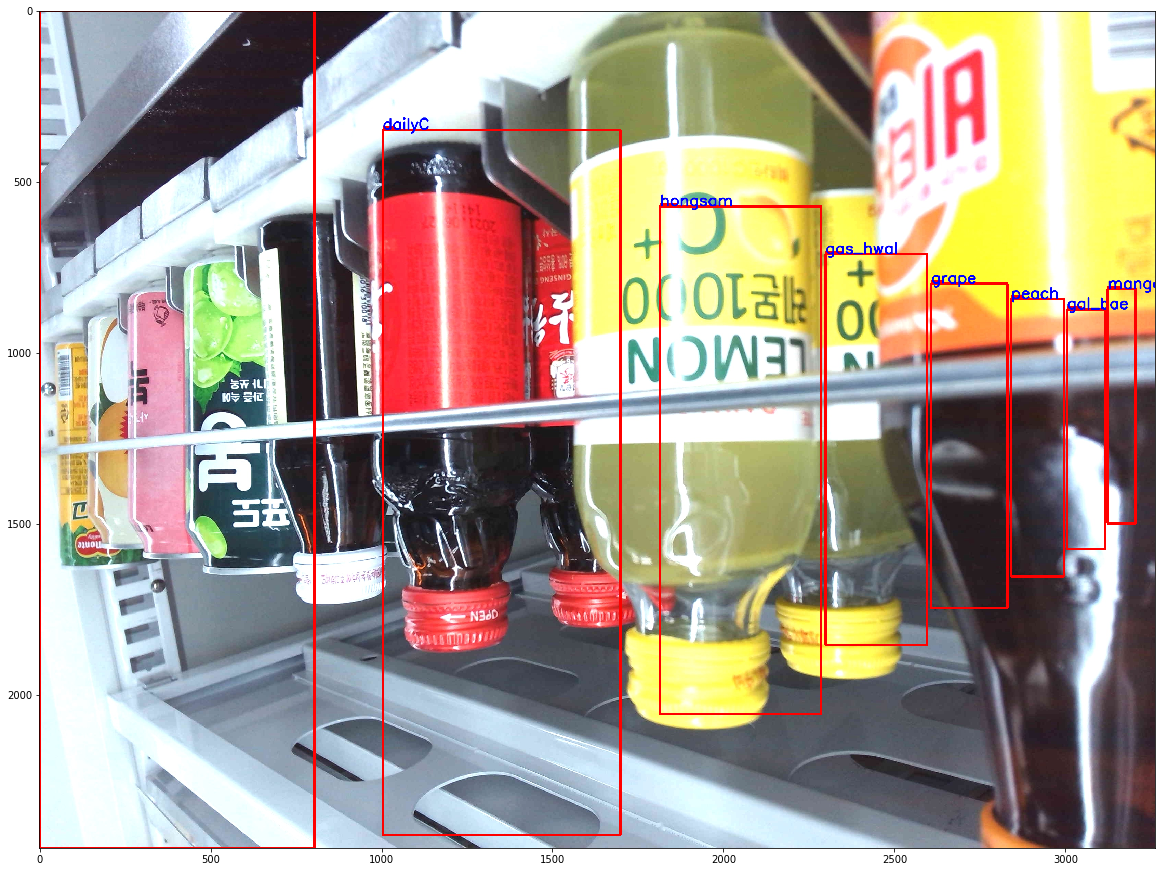

In [158]:
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (0, 0, 255)


img = get_image('../datasets/od_test/image/after_usbcam(2020-03-06-10:56:40).jpg')

xml = '../datasets/od_test/image/after_usbcam(2020-03-06-10:56:40).xml'

root = minidom.parse(xml)
bnd = root.getElementsByTagName('bndbox')
class_name = root.getElementsByTagName('name')

for i in range(len(bnd_1)):
    xmin = int(bnd_1[i].childNodes[1].childNodes[0].nodeValue)
    ymin = int(bnd_1[i].childNodes[3].childNodes[0].nodeValue)
    xmax = int(bnd_1[i].childNodes[5].childNodes[0].nodeValue)
    ymax = int(bnd_1[i].childNodes[7].childNodes[0].nodeValue)

    label = class_name[i].childNodes[0].nodeValue
    
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=BOX_COLOR, thickness=5)
    #class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (xmin, ymin - int(1.3 * text_height)), (xmin + text_width, ymin), BOX_COLOR, -1)
    cv2.putText(img, label, (xmin, ymin - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 1.5,TEXT_COLOR, lineType=cv2.LINE_AA, thickness=3)
    
plt.figure(figsize=(20, 20))
plt.imshow(img)

In [75]:
def get_aug(aug, min_area=0., min_visibility=0.):
    return Compose(aug, bbox_params=BboxParams(format='pascal_voc', min_area=min_area, 
                                               min_visibility=min_visibility, label_fields=['category_id']))

In [40]:
import xml.etree.ElementTree as ET

def read_anntation(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bounding_box_list = []

    file_name = root.find('filename').text
    for obj in root.iter('object'):

        object_label = obj.find("name").text
        for box in obj.findall("bndbox"):
            x_min = int(box.find("xmin").text)
            y_min = int(box.find("ymin").text)
            x_max = int(box.find("xmax").text)
            y_max = int(box.find("ymax").text)

        bounding_box = [object_label, x_min, y_min, x_max, y_max]
        bounding_box_list.append(bounding_box)

    return bounding_box_list, file_name

In [41]:
read_anntation(xml_path)

IsADirectoryError: [Errno 21] Is a directory: './annotations/'

In [52]:
import os
import cv2
import numpy as np

xml_path = './img/'
image_path = './img/'

def read_train_dataset(image_path):
    images = []
    annotations = []

    for file in os.listdir(image_path):
        if 'jpg' in file.lower() or 'png' in file.lower():
            images.append(cv2.imread(image_path + file, 1))
            annotation_file = xml_path + file.split('.')[0] +'.xml'
            bounding_box_list, file_name = read_anntation(annotation_file)
            annotations.append((bounding_box_list, annotation_file, file_name))

    images = np.array(images)

    return images, annotations

In [53]:
read_train_dataset(image_path)[1][1][0]

[['person', 29, 213, 232, 535],
 ['person', 253, 181, 351, 475],
 ['person', 340, 205, 451, 537],
 ['person', 405, 178, 518, 345],
 ['person', 572, 259, 770, 602],
 ['person', 567, 72, 724, 335],
 ['person', 710, 170, 753, 267],
 ['person', 775, 164, 843, 264],
 ['person', 843, 167, 905, 259],
 ['person', 910, 162, 1002, 386],
 ['person', 753, 218, 951, 572]]

In [44]:
xml_path = './annotations/'
image_path = './img/'

xml_path + os.listdir(image_path)[0] +'.xml'

'./annotations/2.xml.xml'

In [45]:
import imgaug as ia
from imgaug import augmenters as iaa
from files import *
import numpy as np
import matplotlib.pyplot as plt


#np.random.bit_generator = np.random._bit_generator

ia.seed(1)

images, annotations = read_train_dataset(image_path)

for idx in range(len(images)):
    image = images[idx]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = annotations[idx][0]

    ia_bounding_boxes = []
    for box in boxes:
        ia_bounding_boxes.append(ia.BoundingBox(x1=box[1], y1=box[2], x2=box[3], y2=box[4]))
    bbs = ia.BoundingBoxesOnImage(ia_bounding_boxes, shape=image.shape)

    seq = iaa.Sequential([
            iaa.Multiply((1.2, 1.5)),
            iaa.Affine(
                #translate_px={"x": 40, "y": 60},
                #scale=(0.5, 0.7),
                rotate=180  # 이미지 회전 추가
            )
        ])

    seq_det = seq.to_deterministic()

    image_aug = seq_det.augment_images([image])[0]
    bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]

    for i in range(len(bbs.bounding_boxes)):
        before = bbs.bounding_boxes[i]
        after = bbs_aug.bounding_boxes[i]
        print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
            i,
            before.x1, before.y1, before.x2, before.y2,
            after.x1, after.y1, after.x2, after.y2)
        )

    image_before = bbs.draw_on_image(image, thickness=20)
    image_after = bbs_aug.draw_on_image(image_aug, thickness=15, color=[0, 0, 255])

    #cv2.imshow('image_before', cv2.resize(image_before, (380, 640)))
    #cv2.imshow('image_after', cv2.resize(image_after, (380, 640)))

    #cv2.waitKey(0)
plt.figure(figsize=(20, 20))
plt.imshow(image_after)

FileNotFoundError: [Errno 2] No such file or directory: './annotations/after_1.xml'

In [56]:
import imgaug as ia
from imgaug import augmenters as iaa
from files import *
from pascal_voc_writer import Writer


#np.random.bit_generator = np.random._bit_generator


xml_path = './img/'
image_path = './img/'

ia.seed(1)

images, annotations = read_train_dataset(image_path)

for idx in range(len(images)):
    image = images[idx]
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = annotations[idx][0]

    ia_bounding_boxes = []
    for box in boxes:
        ia_bounding_boxes.append(ia.BoundingBox(x1=box[1], y1=box[2], x2=box[3], y2=box[4]))
    bbs = ia.BoundingBoxesOnImage(ia_bounding_boxes, shape=image.shape)

    seq = iaa.Sequential([
               iaa.Multiply((0.5, 1.7)),
               iaa.OneOf([
                   iaa.Fliplr(0.5),
                   iaa.Affine(
                   #translate_px={"x": 40, "y": 60},
                   #scale=(0.5, 0.7),
                   rotate=180,
               )])
           ])

    seq_det = seq.to_deterministic()

    image_aug = seq_det.augment_images([image])[0]
    
    bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]

    new_image_file = image_path + 'after_' + annotations[idx][2]
    cv2.imwrite(new_image_file, image_aug)

    h, w = np.shape(image_aug)[0:2]
    voc_writer = Writer(new_image_file, w, h)

    for i in range(len(bbs_aug.bounding_boxes)):
        bb_box = bbs_aug.bounding_boxes[i]
        voc_writer.addObject(boxes[i][0], int(bb_box.x1), int(bb_box.y1), int(bb_box.x2), int(bb_box.y2))

    voc_writer.save(image_path + 'after_' + annotations[idx][1].split('/')[-1])


In [1]:
### Aug Test 용도

import imgaug as ia
from imgaug import augmenters as iaa
from files import *
import xml.etree.ElementTree as ET
import os
import cv2
import numpy as np


xml_path = 'annotations/'
image_path = 'img/'


def read_anntation(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bounding_box_list = []

    file_name = root.find('filename').text
    for obj in root.iter('object'):

        object_label = obj.find("name").text
        for box in obj.findall("bndbox"):
            x_min = int(box.find("xmin").text)
            y_min = int(box.find("ymin").text)
            x_max = int(box.find("xmax").text)
            y_max = int(box.find("ymax").text)

        bounding_box = [object_label, x_min, y_min, x_max, y_max]
        bounding_box_list.append(bounding_box)

    return bounding_box_list, file_name


def read_train_dataset(image_path):
    images = []
    annotations = []

    for file in os.listdir(image_path):
        if 'jpg' in file.lower() or 'png' in file.lower():
            images.append(cv2.imread(image_path + file, 1))
            annotation_file = xml_path + file.split('.')[0] +'.xml'
            bounding_box_list, file_name = read_anntation(annotation_file)
            annotations.append((bounding_box_list, annotation_file, file_name))

    images = np.array(images)

    return images, annotations



np.random.bit_generator = np.random._bit_generator

ia.seed(1)

images, annotations = read_train_dataset(image_path)

for idx in range(len(images)):
    image = images[idx]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = annotations[idx][0]

    ia_bounding_boxes = []
    for box in boxes:
        ia_bounding_boxes.append(ia.BoundingBox(x1=box[1], y1=box[2], x2=box[3], y2=box[4]))
    bbs = ia.BoundingBoxesOnImage(ia_bounding_boxes, shape=image.shape)

    seq = iaa.Sequential([
                iaa.Multiply((0.5, 1.7)),
                iaa.OneOf([
                    iaa.Fliplr(1),
                    iaa.Affine(
                    #translate_px={"x": 40, "y": 60},
                    #scale=(0.5, 0.7),
                    rotate=180,

                )])
            ])

    seq_det = seq.to_deterministic()

    image_aug = seq_det.augment_images([image])[0]
    bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]

    for i in range(len(bbs.bounding_boxes)):
        before = bbs.bounding_boxes[i]
        after = bbs_aug.bounding_boxes[i]
        #print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        #    i,
        #    before.x1, before.y1, before.x2, before.y2,
        #    after.x1, after.y1, after.x2, after.y2)
        #)

    image_before = bbs.draw_on_image(image, thickness=20)
    image_after = bbs_aug.draw_on_image(image_aug, thickness=15, color=[0, 0, 255])

    #cv2.imshow('image_before', cv2.resize(image_before, (380, 640)))
    #cv2.imshow('image_after', cv2.resize(image_after, (380, 640)))

    #cv2.waitKey(0)
plt.figure(figsize=(20, 20))
plt.imshow(image_after)

ModuleNotFoundError: No module named 'files'

In [209]:
import glob
imm = glob.glob(image_path+'*')[1]

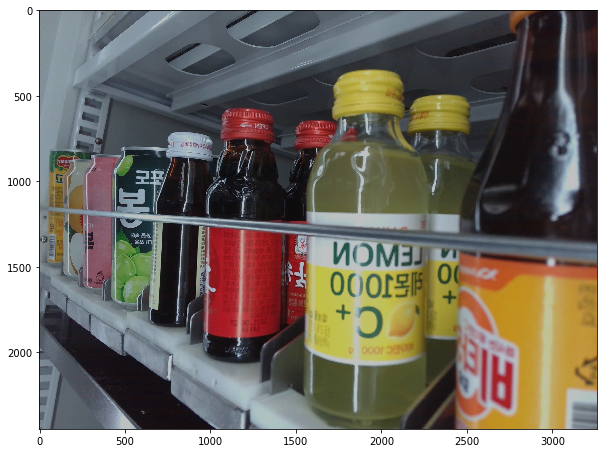

In [345]:
image = cv2.imread(imm)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
seq = iaa.Sequential([
            iaa.Multiply((0.5, 1.7)),
            iaa.OneOf([
                iaa.Fliplr(0.5),
                iaa.Affine(
                #translate_px={"x": 40, "y": 60},
                #scale=(0.5, 0.7),
                rotate=180,
                
            )])
        ])

seq_det = seq.to_deterministic()

image_aug = seq_det.augment_images([image])[0]

plt.figure(figsize=(10, 10))
plt.imshow(image_aug)

In [211]:
imm

'../datasets/od_test/image/usbcam(2020-03-06-10:56:40).jpg'

In [347]:
image_path = '../datasets/od_test/image/'

img_li = glob.glob(image_path+'*')
img_li

['../datasets/od_test/image/usbcam(2020-03-06-15:08:54).jpg',
 '../datasets/od_test/image/usbcam(2020-03-06-10:57:19).jpg',
 '../datasets/od_test/image/usbcam(2020-03-06-10:56:40).jpg',
 '../datasets/od_test/image/usbcam(2020-03-06-15:07:54).jpg',
 '../datasets/od_test/image/usbcam(2020-03-06-15:08:34).jpg']

In [349]:
import random


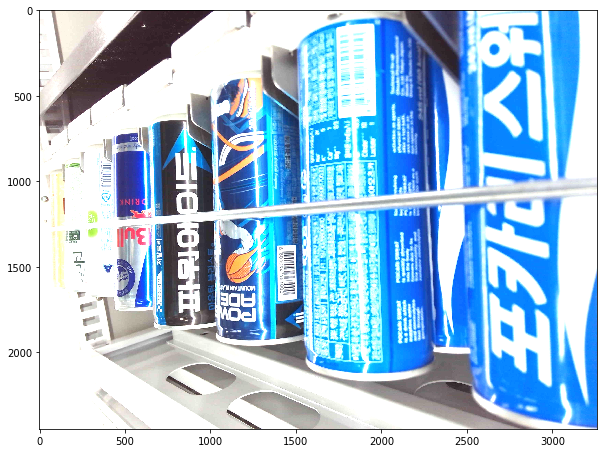

In [403]:
image_path = '../datasets/od_test/image/'

img_li = glob.glob(image_path+'*')

rand_idx = random.randint(0,len(img_li)-1)


image = cv2.imread(img_li[rand_idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
seq = iaa.Sequential([
            iaa.Multiply((0.5, 1.7)),
            iaa.OneOf([
                iaa.Fliplr(0.5),
                iaa.Affine(
                #translate_px={"x": 40, "y": 60},
                #scale=(0.5, 0.7),
                rotate=180,
                
            )])
        ])

seq_det = seq.to_deterministic()

image_aug = seq_det.augment_images([image])[0]

plt.figure(figsize=(10, 10))
plt.imshow(image_aug)